<a href="https://colab.research.google.com/github/itaimorad/Deep-Learning/blob/Part1-Itai/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1. Music Century Classification

**Assignment Responsible**: Natalie Lang.

In this assignment, we will build models to predict which
**century** a piece of music was released.  We will be using the "YearPredictionMSD Data Set"
based on the Million Song Dataset. The data is available to download from the UCI 
Machine Learning Repository. Here are some links about the data:

- https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd
- http://millionsongdataset.com/pages/tasks-demos/#yearrecognition

Note that you are note allowed to import additional packages **(especially not PyTorch)**. One of the objectives is to understand how the training procedure actually operates, before working with PyTorch's autograd engine which does it all for us.


## Question 1. Data (21%)

Start by setting up a Google Colab notebook in which to do your work.
Since you are working with a partner, you might find this link helpful:

- https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb

The recommended way to work together is pair coding, where you and your partner are sitting together and writing code together. 

To process and read the data, we use the popular `pandas` package for data analysis.

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

Now that your notebook is set up, we can load the data into the notebook. The code below provides
two ways of loading the data: directly from the internet, or through mounting Google Drive.
The first method is easier but slower, and the second method is a bit involved at first, but
can save you time later on. You will need to mount Google Drive for later assignments, so we recommend
figuring how to do that now.

Here are some resources to help you get started:

- http.://colab.research.google.com/notebooks/io.ipynb

In [2]:
load_from_drive = False

if not load_from_drive:
  csv_path = "http://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip"
else:
  from google.colab import drive
  drive.mount('/content/gdrive')
  csv_path = '/content/gdrive/My Drive/YearPredictionMSD.txt.zip' # TODO - UPDATE ME WITH THE TRUE PATH!

t_label = ["year"]
x_labels = ["var%d" % i for i in range(1, 91)]
df = pandas.read_csv(csv_path, names=t_label + x_labels)

Now that the data is loaded to your Colab notebook, you should be able to display the Pandas
DataFrame `df` as a table:

In [3]:
df

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.0500

To set up our data for classification, we'll use the "year" field to represent
whether a song was released in the 20-th century. In our case `df["year"]` will be 1 if
the year was released after 2000, and 0 otherwise.

In [5]:
df["year"] = df["year"].map(lambda x: int(x > 2000))

In [6]:
df.head(20)

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,1,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,1,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,1,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,1,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,1,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34

### Part (a) -- 7%

The data set description text asks us to respect the below train/test split to
avoid the "producer effect". That is, we want to make sure that no song from a single artist
ends up in both the training and test set.

Explain why it would be problematic to have
some songs from an artist in the training set, and other songs from the same artist in the
test set. (Hint: Remember that we want our test accuracy to predict how well the model
will perform in practice on a song it hasn't learned about.)

In [7]:
df_train = df[:463715]
df_test = df[463715:]

# convert to numpy
train_xs = df_train[x_labels].to_numpy()
train_ts = df_train[t_label].to_numpy()
test_xs = df_test[x_labels].to_numpy()
test_ts = df_test[t_label].to_numpy()

# Write your explanation here
'''
The performance of the trained model on the training set is not representive of the actual "real life" perforamnce,
since its can be just overfitted. Meaning the parameters we learned are just too optimized to the training set.
If we include the training set values in the testing set it will result to falsely good parameters that could not
handle "real-life" or unseen input values, hence we shall not mix the training set with the testing set.

'''

'\nThe performance of the trained model on the training set is not representive of the actual "real life" perforamnce,\nsince its can be just overfitted. Meaning the parameters we learned are just too optimized to the training set.\nIf we include the training set values in the testing set it will result to falsely good parameters that could not\nhandle "real-life" or unseen input values, hence we shall not mix the training set with the testing set.\n\n'

### Part (b) -- 7%

It can be beneficial to **normalize** the columns, so that each column (feature)
has the *same* mean and standard deviation.

In [8]:
feature_means = df_train.mean()[1:].to_numpy() # the [1:] removes the mean of the "year" field
feature_stds  = df_train.std()[1:].to_numpy()

train_norm_xs = (train_xs - feature_means) / feature_stds
test_norm_xs = (test_xs - feature_means) / feature_stds

Notice how in our code, we normalized the test set using the *training data means and standard deviations*.
This is *not* a bug.

Explain why it would be improper to compute and use test set means
and standard deviations. (Hint: Remember what we want to use the test accuracy to measure.)

In [9]:
# Write your explanation here
'''
Normalized by mean and sd (standard deviation) of the training data set means we made a new variables that we will 
probably use to train the model. In order to use this variables to validate our test set we need to make the same variables in the training set.
If we used different mean and sd we would make different variables so the test won't be coherent with the training set and the testing results won't be reliable.
'''

"\nNormalized by mean and sd (standard deviation) of the training data set means we made a new variables that we will \nprobably use to train the model. In order to use this variables to validate our test set we need to make the same variables in the training set.\nIf we used different mean and sd we would make different variables so the test won't be coherent with the training set and the testing results won't be reliable.\n"

### Part (c) -- 7%

Finally, we'll move some of the data in our training set into a validation set.

Explain why we should limit how many times we use the test set, and that we should use the validation
set during the model building process.

In [10]:
# shuffle the training set
reindex = np.random.permutation(len(train_xs))
train_xs = train_xs[reindex]
train_norm_xs = train_norm_xs[reindex]
train_ts = train_ts[reindex]

# use the first 50000 elements of `train_xs` as the validation set
train_xs, val_xs           = train_xs[50000:], train_xs[:50000]
train_norm_xs, val_norm_xs = train_norm_xs[50000:], train_norm_xs[:50000]
train_ts, val_ts           = train_ts[50000:], train_ts[:50000]

# Write your explanation here
'''
Since we are using the validation set as part of the training in order to tune the training the model prarameters,
we cant use it again as a test set.
Thus making our testing set smaller, that limits us because our testing set should be big enough to give us reliable test results.
'''

'\nSince we are using the validation set as part of the training in order to tune the training the model prarameters,\nwe cant use it again as a test set.\nThus making our testing set smaller, that limits us because our testing set should be big enough to give us reliable test results.\n'

## Part 2. Classification (79%)

We will first build a *classification* model to perform decade classification.
These helper functions are written for you. All other code that you write in this section should be vectorized whenever possible (i.e., avoid unnecessary loops).

In [11]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))
    
def cross_entropy(t, y):
  return -t * np.log(y) - (1 - t) * np.log(1 - y)

def cost(y, t):
  return np.mean(cross_entropy(t, y))

def get_accuracy(y, t):
  acc = 0
  N = 0
  for i in range(len(y)):
    N += 1
    if (y[i] >= 0.5 and t[i] == 1) or (y[i] < 0.5 and t[i] == 0):
      acc += 1
  return acc / N

### Part (a) -- 7%

Write a function `pred` that computes the prediction `y` based on logistic regression, i.e., a single layer with weights `w` and bias `b`. The output is given by: 
\begin{equation}
y = \sigma({\bf w}^T {\bf x} + b),
\end{equation}
where the value of $y$ is an estimate of the probability that the song is released in the current century, namely ${\rm year} =1$.

In [12]:
def pred(w, b, X):
  """
  Returns the prediction `y` of the target based on the weights `w` and scalar bias `b`.

  Preconditions: np.shape(w) == (90,)
                 type(b) == float
                 np.shape(X) = (N, 90) for some N

  >>> pred(np.zeros(90), 1, np.ones([2, 90]))
  array([0.73105858, 0.73105858]) # It's okay if your output differs in the last decimals
  """
  
  # Your code goes here
  z = np.dot(X,w) + b
  y = sigmoid(z)
  return y
pred(np.zeros(90), 1, np.ones([2, 90]))

array([0.73105858, 0.73105858])

### Part (b) -- 7%

Write a function `derivative_cost` that computes and returns the gradients 
$\frac{\partial\mathcal{L}}{\partial {\bf w}}$ and
$\frac{\partial\mathcal{L}}{\partial b}$. Here, `X` is the input, `y` is the prediction, and `t` is the true label.




In [13]:
def derivative_cost(X, y, t):
  """
  Returns a tuple containing the gradients dLdw and dLdb.

  Precondition: np.shape(X) == (N, 90) for some N
                np.shape(y) == (N,)
                np.shape(t) == (N,)

  Postcondition: np.shape(dLdw) = (90,)
           type(dLdb) = float
  """
  # Your code goes here
  # The loss function of is the cross-entropy defined above. in order to obtain dl/dw we use the chain 
  # rule: dl/dw = dl/dy*dy/dz*dz/dw, and the same goes for b: dl/db = dl/dy*dy/dz*dz/dw
  #dl/dy = -t/y + (1-t)/(1-y)
  #dy/dz = sigmoid(z)(1-sigmoid(z)) = y(1-y)
  #dz/dw = X
  #dz/db = 1
  #therefor we get dl/db = y-t
  #and dl/dw = (y-t)x
  #now we use: L=1/N*sum(l)
  #dL/db = 1/N*sum(y-t) = mean(y-t)
  #dL/dw = 1/N*sum(y-t)X = (y-t)dotX*(1/N)
  dLdw = np.dot(y-t,X)/len(y);
  dLdb = np.mean(y-t);
  return (dLdw,dLdb)

# **Explenation on Gradients**




**Add here an explaination on how the gradients are computed**:

Write your explanation here. Use Latex to write mathematical expressions. [Here is a brief tutorial on latex for notebooks.](https://www.math.ubc.ca/~pwalls/math-python/jupyter/latex/)



### Part (c) -- 7%

We can check that our derivative is implemented correctly using the finite difference rule. In 1D, the
finite difference rule tells us that for small $h$, we should have

$$\frac{f(x+h) - f(x)}{h} \approx f'(x)$$

Show that $\frac{\partial\mathcal{L}}{\partial b}$  is implement correctly
by comparing the result from `derivative_cost` with the empirical cost derivative computed using the above numerical approximation.


In [ ]:
# Your code goes here

#First lets choose the wieghts and the vectors to take on derivative\
b=0
X= train_norm_xs[:50]
t =train_ts[:50,0]
h = 0.01 #small enough for this values
w = np.sqrt(1/len(train_norm_xs))*np.random.randn(90)

#Calculation of derivative with our function
y = pred(w,b,X)
D1 = derivative_cost(X, y, t)

#Algorithm way
#Using the same w but changing the the b
D2 = (np.mean(cross_entropy(t,pred(w,b+h,X)))-np.mean(cross_entropy(t,pred(w,b,X))))/h

r1= D1[1] #(dw,db) so we need the second cell
r2= D2.T
diff = abs(r2-r1)
print("The analytical results is -", r1)
print("The algorithm results is - ", r2)
print("The difference is - ", diff)




The analytical results is - -0.06034548186362953
The algorithm results is -  -0.05909551518396006
The difference is -  0.0012499666796694717


### Part (d) -- 7%

Show that $\frac{\partial\mathcal{L}}{\partial {\bf w}}$  is implement correctly.

In [ ]:
# Your code goes here. You might find this below code helpful: but it's
# up to you to figure out how/why, and how to modify the code

D2 = []
#Calculation with h
for i in range(90):
  dw = w.copy()
  dw.put(i,w[i]+h)
  D2 = np.append(D2,(np.mean(cross_entropy(t,pred(dw,b,X)))-np.mean(cross_entropy(t,pred(w,b,X))))/h)


r1= D1[0]
r2= D2.T
diff = abs(r2-r1)
print("The analytical results is -", r1)
print("The algorithm results is - ", r2)
print("The difference is - ", diff)

The analytical results is - [-0.17507772  0.0162413  -0.09392061  0.02284921  0.02091123  0.03723831
  0.03275722 -0.08411639 -0.04951385 -0.03049656  0.047105    0.02570361
 -0.03421102 -0.062715    0.07661592  0.01269314  0.0444433   0.04517859
  0.07606284 -0.02638305  0.02623464  0.02993372 -0.01925658  0.02160035
 -0.12179695  0.01358127  0.03501042  0.03650589 -0.02448727  0.07665322
 -0.00688018  0.00432322  0.08022372  0.01450662  0.01825918  0.01557322
  0.08455738  0.00520005  0.01924462  0.00609661  0.19204848  0.05512371
 -0.03059719 -0.11410114 -0.02489638  0.07416815 -0.10157832  0.00476903
  0.06497662  0.02846183  0.02919148  0.0324732  -0.17679398  0.02639622
  0.05002348  0.04208477  0.11522481 -0.01299458  0.08579859  0.02344421
 -0.06920688 -0.01622201  0.08584755 -0.00068017  0.04712824  0.06516509
 -0.00546924  0.00088245 -0.03467413  0.05252467  0.02603073  0.00212255
  0.07102549 -0.0077104   0.09179967 -0.01689552  0.05316107  0.05464399
  0.06686684 -0.0131005

### Part (e) -- 7%

Now that you have a gradient function that works, we can actually run gradient descent. 
Complete the following code that will run stochastic: gradient descent training:

In [ ]:
def run_gradient_descent(w0, b0, mu=0.1, batch_size=100, max_iters=100):
  """Return the values of (w, b) after running gradient descent for max_iters.
  We use:
    - train_norm_xs and train_ts as the training set
    - val_norm_xs and val_ts as the test set
    - mu as the learning rate
    - (w0, b0) as the initial values of (w, b)

  Precondition: np.shape(w0) == (90,)
                type(b0) == float
 
  Postcondition: np.shape(w) == (90,)
                 type(b) == float
  """
  w = w0
  b = b0
  iter = 0

  val_accuracy = []
  val_cost = []
  train_accuracy = []
  train_cost = []
  epochs = []

  while iter < max_iters:
    # shuffle the training set (there is code above for how to do this)
    reindex = np.random.permutation(len(train_xs))
    traning_norm_shuffled = train_norm_xs[reindex]
    traning_ts_shuffled = train_ts[reindex]

    for i in range(0, len(train_norm_xs), batch_size): # iterate over each minibatch
      # minibatch that we are working with:
      X = traning_norm_shuffled[i:(i + batch_size)]
      t = traning_ts_shuffled[i:(i + batch_size), 0]

      # since len(train_norm_xs) does not divide batch_size evenly, we will skip over
      # the "last" minibatch
      if np.shape(X)[0] != batch_size:
        continue

      # compute the prediction
      y = pred(w, b, X)
      train_accuracy.append(get_accuracy(y,t))
      train_cost.append(cost(y,t))

      # update w and b
      dw,db = derivative_cost(X,y,t)
      w = w - dw*mu
      b = b - db*mu

      # increment the iteration count
      iter += 1
      # compute and print the *validation* loss and accuracy
      a = 0
      if (iter % 10 == 0):
        validation_y = pred(w,b,val_norm_xs)
        val_accuracy.append(get_accuracy(validation_y,val_ts[:,0]))
        #print(val_y,val_ts[:,0])
        val_cost.append(cost(validation_y,val_ts[:,0]))
        #print("Iter %d. [Val Acc %.0f%%, Loss %f]" % (iter, val_acc[a] * 100, val_cost[a]))
      a=a+1
      if iter >= max_iters:
        break

      # Think what parameters you should return for further use
      epochs.append(iter) 

  return val_accuracy, val_cost, epochs, w, b, train_cost, train_accuracy

### Part (f) -- 7%

Call `run_gradient_descent` with the weights and biases all initialized to zero.
Show that if the learning rate $\mu$ is too small, then convergence is slow.
Also, show that if $\mu$ is too large, then the optimization algorirthm does not converge. The demonstration should be made using plots showing these effects.

In [ ]:
len(train_norm_xs)

413715

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


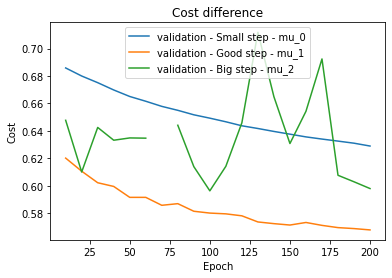

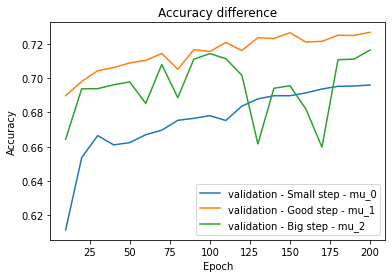

In [ ]:

w0 = np.zeros(90)
b0 = b0 = np.float(0)

# Write your code here
batch_size = 100
max_iters = 200

# we will choose 3 different values for a mu: 0.01, 0.1, 1
mu_0 = 0.01
mu_1 = 0.1
mu_2 = 1

val_acc_0, val_cost_0, epochs_0, w0, b0, _, _ = run_gradient_descent(w0,b0, mu_0, batch_size, max_iters)
val_acc_1, val_cost_1, epochs_1, w1, b1, _, _ = run_gradient_descent(w0,b0, mu_1, batch_size, max_iters)
val_acc_2, val_cost_2, epochs_2, w2, b2, _, _ = run_gradient_descent(w0,b0, mu_2, batch_size, max_iters)


# First lets make a plots of the cost graph
plt.title("Cost difference")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.plot(np.linspace(10,max_iters,len(val_cost_0)), val_cost_0, label="validation - Small step - mu_0")
plt.plot(np.linspace(10,max_iters,len(val_cost_1)), val_cost_1, label="validation - Good step - mu_1")
plt.plot(np.linspace(10,max_iters,len(val_cost_2)), val_cost_2, label="validation - Big step - mu_2")
plt.legend(loc='best')
plt.show()

# Now lets make a plots for the accuracy graph
plt.title("Accuracy difference")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(np.linspace(10,max_iters,len(val_acc_0)), val_acc_0, label="validation - Small step - mu_0")
plt.plot(np.linspace(10,max_iters,len(val_acc_1)), val_acc_1, label="validation - Good step - mu_1")
plt.plot(np.linspace(10,max_iters,len(val_acc_2)), val_acc_2, label="validation - Big step - mu_2")
plt.legend(loc='best')
plt.show()


**Explain and discuss your results here:**


### Part (g) -- 7%

Find the optimial value of ${\bf w}$ and $b$ using your code. Explain how you chose
the learning rate $\mu$ and the batch size. Show plots demostrating good and bad behaviours.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


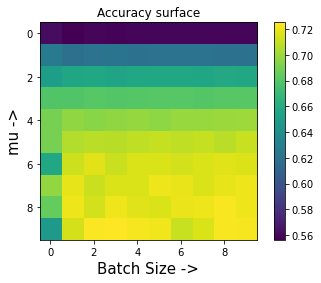

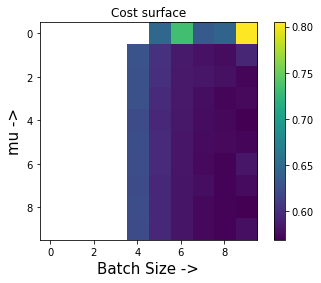

In [ ]:
w0 = np.random.randn(90)
b0 = np.random.randn(1)[0]

# Write your code here
MU = np.linspace(0.1,1.2,10)
BS = np.linspace(100,6000,10,dtype = np.int)

Accuracy = np.zeros([len(MU),len(BS)])
Cost = np.zeros([len(MU),len(BS)])
i=0
for mu in MU:
  j = 0
  for batch_size in BS:
    val_acc, val_cost, epochs, w, b, _, _ = run_gradient_descent(w0,b0, mu, batch_size,100)
    Accuracy[i,j] = get_accuracy(pred(w,b,test_norm_xs),test_ts[:,0])
    Cost[j,i] = cost(pred(w,b,test_norm_xs),test_ts[:,0])
    j = j +1
  i = i+1

# Compute loss for each grid point
plt.figure()
plt.title('Accuracy surface')
plt.xlabel("Batch Size ->", fontsize=15)
plt.ylabel("mu ->", rotation=90, fontsize=15)
plt.imshow(Accuracy)
plt.colorbar()


plt.figure()
plt.title('Cost surface')
plt.xlabel("Batch Size ->", fontsize=15)
plt.ylabel("mu ->", rotation=90, fontsize=15)
plt.imshow(Cost)
plt.colorbar()



In [ ]:

#Now lets choosethe values with the maximum Accuracy
max_index = np.where(Accuracy == np.amax(Accuracy))
best_mu = MU[max_index[0]]
best_bs = BS[max_index[1]]

print(f"The optimal mu is: {best_mu}")
print(f"The optimal batch size is: {best_bs}")

The optimal mu is: [1.2]
The optimal batch size is: [2066]


**Explain and discuss your results here:**




### Part (h) -- 15%

Using the values of `w` and `b` from part (g), compute your training accuracy, validation accuracy,
and test accuracy. Are there any differences between those three values? If so, why?

In [ ]:
# Write your code here
val_acc, val_cost, epochs, w, b, train_cost, train_accuracy = run_gradient_descent(w0,b0, best_mu, int(best_bs),100)

train_acc =get_accuracy(pred(w,b,train_norm_xs),train_ts[:,0]) 
val_acc = get_accuracy(pred(w,b,val_norm_xs),val_ts[:,0]) 
test_acc = get_accuracy(pred(w,b,test_norm_xs),test_ts[:,0])

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


train_acc =  0.7296713921419334  val_acc =  0.73398  test_acc =  0.7246368390470657


**Explain and discuss your results here:**


### Part (i) -- 15%

Writing a classifier like this is instructive, and helps you understand what happens when
we train a model. However, in practice, we rarely write model building and training code
from scratch. Instead, we typically use one of the well-tested libraries available in a package.

Use `sklearn.linear_model.LogisticRegression` to build a linear classifier, and make predictions about the test set. Start by reading the
[API documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Compute the training, validation and test accuracy of this model.

In [ ]:
import sklearn.linear_model

model = ...

train_acc = ...
val_acc = ...
test_acc = ...

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)

train_acc =  Ellipsis  val_acc =  Ellipsis  test_acc =  Ellipsis


**This parts helps by checking if the code worked.**
**Check if you get similar results, if not repair your code**
